In [1]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

sys.path.append("../../stimuli/block_utils/")
import blockworld_utils as utils

In [2]:
experiment_name = 'zipping'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

# Make dataframes

In [5]:
# set vars 
auth = pd.read_csv(os.path.join(proj_dir, 'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['zipping']

# which iteration name should we use?
# iteration_name = 'pilot_1'
iteration_name = 'pre_post_run_0'
iteration_names = [iteration_name]

In [93]:
# metadata
# TODO: check this works
query = coll.find({"$and":[
                        {'datatype':'metadata'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_meta = pd.DataFrame(query)
print(len(df_meta))

103


In [94]:
# survey
query = coll.find({"$and":[
                        {'trial_type':'survey-text'},
                        {'iterationName': { '$in': iteration_names }}, #use this if one iteration name
                        ]})
df_survey = pd.DataFrame(query)
df_survey
list(df_survey['response'])

[{'technical': 'No', 'confused': 'No', 'comments': 'N/A'},
 {'technical': 'No', 'confused': 'No', 'comments': 'No'},
 {'technical': '', 'confused': '', 'comments': ''},
 {'technical': 'No', 'confused': 'No', 'comments': 'No'},
 {'technical': 'o', 'confused': 'no', 'comments': 'none'},
 {'technical': '', 'confused': '', 'comments': ''},
 {'technical': 'no', 'confused': 'no', 'comments': 'no'},
 {'technical': 'no', 'confused': 'no', 'comments': 'no'},
 {'technical': 'no', 'confused': 'no', 'comments': 'it was good'},
 {'technical': 'no',
  'confused': 'In part two, it took me a while to realise I had to build the shape from the bottom up',
  'comments': ''},
 {'technical': 'no', 'confused': 'no', 'comments': ''},
 {'technical': 'No',
  'confused': 'No',
  'comments': 'Interesting - I got lots more correct after the block building activity.'},
 {'technical': 'No issues at all',
  'confused': 'I fully understood the instructions',
  'comments': 'It was challenging but enjoyable'},
 {'techn

In [95]:
# zipping trials
query = coll.find({"$and":[
                        {'trial_type':'tower-zipping'},
                        {'iterationName': { '$in': iteration_names}}, #use this if one iteration name
                        ]})
df_zip = pd.DataFrame(query)
print(len(df_zip))

13735


In [96]:
# building trials
query = coll.find({"$and":[
                        {'trial_type':'block-construction'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_build = pd.DataFrame(query)
print(len(df_build))

1486


In [97]:
# block placements
query = coll.find({"$and":[
                        {'datatype':'block_placement'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_block_placements = pd.DataFrame(query)
print(len(df_block_placements))

8381


In [98]:
# block placements
query = coll.find({"$and":[
                        {'datatype':'reset'},
                        {'iterationName': { '$in': iteration_names }},
                        ]})
df_resets = pd.DataFrame(query)
print(len(df_resets))

2238


### Apply exclusion criteria

In [99]:
remove_tests = False

if remove_tests:
    df_zip = df_zip[~df_zip.workerID.isna()]
    df_build = df_build[~df_build.workerID.isna()]
    df_survey = df_survey[~df_survey.workerID.isna()]

In [100]:
# remove incomplete datasets
a = df_zip.groupby('gameID').apply(len) == 148
complete_zipping_set_gameIDs = list(a[a].index)
df_zip = df_zip[df_zip.gameID.isin(complete_zipping_set_gameIDs)]
df_build = df_build[df_build.gameID.isin(complete_zipping_set_gameIDs)]

In [101]:
incomplete_zipping_set_gameIDs = list(a[~a].index)

In [102]:
print(str(len(incomplete_zipping_set_gameIDs)) + ' ppts removed for incomplete data')
print(str(len(complete_zipping_set_gameIDs)) + ' ppts left')

10 ppts removed for incomplete data
87 ppts left


In [103]:
# low accuracy
p = df_zip.groupby('gameID').response_correct.mean() > 0.5
ppt_greater_chance = list(p[p].index)
print(str(len(df_zip.groupby('gameID')) - len(ppt_greater_chance)) + ' ppts removed for low accuracy')

df_zip = df_zip[df_zip.gameID.isin(ppt_greater_chance)].reset_index()
print(str(len(ppt_greater_chance)) + ' ppts left')

3 ppts removed for low accuracy
84 ppts left


In [104]:
# TODO: flag button bashers
# key_presses is the number of times a key was pressed minus one.
df_zip.key_presses

0        0
1        0
2        0
3        0
4        0
        ..
12427    0
12428    0
12429    0
12430    0
12431    0
Name: key_presses, Length: 12432, dtype: int64

In [105]:
# flag fast RTs
df_zip.loc[:,'flagRT'] = False
df_zip.loc[(df_zip.rt > 5000), 'flagRT'] = True

In [106]:
print('{} trials flagged for slow RT'.format(df_zip['flagRT'].sum()))

62 trials flagged for slow RT


#### remove practice trials from df_zip

In [20]:
df_zip_practice = df_zip[df_zip.practice]
df_zip = df_zip[df_zip.practice == False]

## Add useful columns

In [108]:
# construct compatible variable
'''
A trial is compatible if the parts displayed are of the same orientation (wide/tall)
as the parts of that composite that were built.
If no parts of the composite were built, the trial is 'novel'. 
'''

df_zip.loc[:,'compatibility'] = 'novel'

df_zip.loc[((df_zip.compatible_condition == 'build_tall') & (df_zip.part_type == 'tall')) |
        ((df_zip.compatible_condition == 'build_wide') & (df_zip.part_type == 'wide')), 'compatibility'] = 'compatible'


df_zip.loc[((df_zip.compatible_condition == 'build_tall') & (df_zip.part_type == 'wide')) |
        ((df_zip.compatible_condition == 'build_wide') & (df_zip.part_type == 'tall')), 'compatibility'] = 'incompatible'

In [109]:
# is response_correct as we expect
df_zip.loc[:,'expected_response'] = df_zip.apply(lambda row: row.response_key_dict[row.validity],axis=1)
df_zip.loc[:,'recalculated_response_correct'] = df_zip.expected_response == df_zip.response
assert((df_zip.recalculated_response_correct == df_zip.response_correct).all())

In [110]:
df_zip = df_zip.merge(df_meta[['gameID','rotation_name']], on='gameID', how='left')

# Test experiment design

In [111]:
df_zip[['compatibility','part_type','validity','part_a','part_b','composite_id']]

,compatibility,part_type,validity,part_a,part_b,composite_id
0,novel,tall,valid,025,023,None
1,novel,wide,valid,025,023,None
2,novel,tall,invalid,025,023,None
3,novel,wide,invalid,025,023,None
4,novel,tall,valid,025,023,None
...,...,...,...,...,...,...
12427,novel,wide,valid,wide_011,wide_015,talls_111_127
12428,compatible,tall,valid,tall_102,tall_122,talls_102_122
12429,incompatible,wide,valid,wide_025,wide_010,talls_102_122
12430,incompatible,tall,invalid,tall_101,tall_111,talls_101_114


In [66]:
# # check how many of each rotation for data collection
# df_zip_ppts = df_zip.groupby('gameID').first().merge(df_meta[['gameID','rotation_name']], on='gameID', how='left')
# df_zip_ppts.groupby('rotation_name').count()

Accidentally collected extra participants for r_1 and r_2.
Todo: Remove extras and ensure analyses are consistent when dropping different participants.

In [112]:
built_chunk_array = df_build.groupby('gameID').chunk_id.unique().apply(np.sort)
built_chunk_df = built_chunk_array.reset_index()
built_chunk_df = built_chunk_df.rename(columns={'chunk_id':'built_chunks'})

In [113]:
df_build = df_build.merge(built_chunk_df, how='left', on='gameID')
df_zip = df_zip.merge(built_chunk_df, how='left', on='gameID')

In [29]:
# df_meta_built = df_meta.groupby('gameID').building_chunks.first().apply(np.sort).reset_index()
# df_zip = df_zip.merge(df_meta_built, how='left', on='gameID')

In [114]:
df_zip.built_chunks

0        [tall_102, tall_122, wide_011, wide_015]
1        [tall_102, tall_122, wide_011, wide_015]
2        [tall_102, tall_122, wide_011, wide_015]
3        [tall_102, tall_122, wide_011, wide_015]
4        [tall_101, tall_114, wide_010, wide_025]
                           ...                   
12427    [tall_102, tall_122, wide_008, wide_019]
12428    [tall_102, tall_122, wide_008, wide_019]
12429    [tall_102, tall_122, wide_008, wide_019]
12430    [tall_102, tall_122, wide_008, wide_019]
12431    [tall_102, tall_122, wide_008, wide_019]
Name: built_chunks, Length: 12432, dtype: object

In [115]:
# Double check that compatible actually had those parts built 

a = df_zip[(df_zip.part_type=='tall') & 
       (df_zip.compatibility=='compatible')].actual_tall_parts.apply(np.sort)

b = df_zip[(df_zip.part_type=='tall') & 
       (df_zip.compatibility=='compatible')].built_chunks.apply(lambda part_list: np.sort([part for part in part_list if 'tall' in part]))

a.equals(b)

True

In [189]:
df_zip.groupby(['gameID','phase','compatibility']).apply(len)

gameID                                     phase                compatibility
0006-45bd8004-9f80-4c7f-aba2-610e170754cb  post_zipping_trials  compatible       24
                                                                incompatible     24
                                                                novel            24
                                           pre_zipping_trials   compatible       24
                                                                incompatible     24
                                                                                 ..
9984-ef648e44-23bb-4658-96f4-7be5c145c151  post_zipping_trials  incompatible     24
                                                                novel            24
                                           pre_zipping_trials   compatible       24
                                                                incompatible     24
                                                                novel            2

In [204]:
df_zip[df_zip.phase == "post_zipping_trials"].sort_values('trial_start_time').groupby(['gameID']).first()

,index,_id,trial_start_time,trial_finish_time,rt,stimulus,response,response_correct,stimURL,practice,...,actual_wide_parts,trial_num,block,phase,flagRT,compatibility,expected_response,recalculated_response_correct,rotation_name,built_chunks
gameID,,,,,,,,,,,,,,,,,,,,,
0006-45bd8004-9f80-4c7f-aba2-610e170754cb,668,62c7270cedff9c124677524a,1.657219e+12,1.657219e+12,1702.0,https://tower-4-block-unique-silhouettes-compo...,m,0,https://tower-4-block-unique-silhouettes-compo...,False,...,"[wide_019, wide_008]",72.0,post_0,post_zipping_trials,False,incompatible,z,False,r_2,"[tall_101, tall_114, wide_011, wide_015]"
0194-7c828eff-b5e0-4ebc-8d76-c3cb58fefe35,9296,62c76b8dedff9c1246779286,1.657236e+12,1.657236e+12,874.7,https://tower-4-block-unique-silhouettes-compo...,z,0,https://tower-4-block-unique-silhouettes-compo...,False,...,"[wide_019, wide_008]",72.0,post_0,post_zipping_trials,False,novel,m,False,p_1,"[tall_102, tall_122, wide_011, wide_015]"
0462-c64aea8d-3207-416f-b75e-9ad1e371c8c1,5490,62c75094edff9c1246777605,1.657229e+12,1.657229e+12,756.4,https://tower-4-block-unique-silhouettes-compo...,m,0,https://tower-4-block-unique-silhouettes-compo...,False,...,"[wide_025, wide_010]",72.0,post_0,post_zipping_trials,False,novel,z,False,r_2,"[tall_101, tall_114, wide_011, wide_015]"
0583-6b2d7882-0eab-45f9-a075-192f478b0256,6009,62c75193edff9c1246777aa1,1.657230e+12,1.657230e+12,1377.8,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,False,...,"[wide_011, wide_015]",72.0,post_0,post_zipping_trials,False,incompatible,z,True,p_2,"[tall_111, tall_127, wide_010, wide_025]"
0642-3e57e41e-831c-4209-b40a-dd7c5bde1e97,596,62c72411edff9c1246775129,1.657218e+12,1.657218e+12,1085.0,https://tower-4-block-unique-silhouettes-compo...,z,0,https://tower-4-block-unique-silhouettes-compo...,False,...,"[wide_025, wide_010]",72.0,post_0,post_zipping_trials,False,compatible,m,False,q_2,"[tall_102, tall_122, wide_008, wide_019]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8604-17243e13-050c-4c1a-b0b6-55c31b777cfa,13071,62c7a13eedff9c124677b1b1,1.657250e+12,1.657250e+12,2563.6,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,False,...,"[wide_011, wide_015]",72.0,post_0,post_zipping_trials,False,novel,m,True,None,"[tall_101, tall_114, wide_010, wide_025]"
9120-19f24161-e3be-4c42-8796-3429380b5dd2,7180,62c7559eedff9c1246778246,1.657231e+12,1.657231e+12,1481.8,https://tower-4-block-unique-silhouettes-compo...,m,0,https://tower-4-block-unique-silhouettes-compo...,False,...,"[wide_019, wide_008]",72.0,post_0,post_zipping_trials,False,novel,z,False,p_1,"[tall_102, tall_122, wide_011, wide_015]"
9663-a33e352b-c21f-46a2-b422-70bce3486bc9,8645,62c76a30edff9c1246778b7d,1.657236e+12,1.657236e+12,859.1,https://tower-4-block-unique-silhouettes-compo...,z,1,https://tower-4-block-unique-silhouettes-compo...,False,...,"[wide_025, wide_010]",72.0,post_0,post_zipping_trials,False,incompatible,z,True,q_2,"[tall_102, tall_122, wide_008, wide_019]"


In [231]:
pre_start = df_zip[df_zip.trial_num == 0.0][['gameID','trial_start_time']]
pre_finish = df_zip[df_zip.trial_num == 71.0][['gameID','trial_finish_time']]

pre_timing = pre_start.merge(pre_finish)
pre_timing['pre_duration'] = pre_timing['trial_finish_time'] - pre_timing['trial_start_time']
pre_timing['pre_duration_min'] = pre_timing['pre_duration'] / (1000 * 60)
pre_timing

,gameID,trial_start_time,trial_finish_time,pre_duration,pre_duration_min
0,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,1.657217e+12,1.657217e+12,370724.0,6.178733
1,1287-eae5bf2b-2731-4660-a20e-b73b9dbe4624,1.657217e+12,1.657217e+12,392282.0,6.538033
2,0642-3e57e41e-831c-4209-b40a-dd7c5bde1e97,1.657217e+12,1.657217e+12,391674.0,6.527900
3,2817-b371118e-ed53-4f8c-a570-8948cf2a0123,1.657217e+12,1.657217e+12,371049.0,6.184150
4,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,1.657217e+12,1.657218e+12,396554.0,6.609233
...,...,...,...,...,...
79,8604-17243e13-050c-4c1a-b0b6-55c31b777cfa,1.657249e+12,1.657250e+12,417902.0,6.965033
80,7197-823dff6e-3420-4b62-8128-e1034077ad07,1.657254e+12,1.657255e+12,422204.0,7.036733
81,7447-da0c7da5-12fd-4bf9-96b2-75a00cc5cd8b,1.657294e+12,1.657295e+12,455407.0,7.590117
82,7428-1efc75e2-2045-46b6-b8a9-a38ffc9d7c63,1.657296e+12,1.657297e+12,367019.0,6.116983


In [257]:
post_start = df_zip[df_zip.trial_num == 72.0][['gameID','trial_start_time']]
post_finish = df_zip[df_zip.trial_num == 143.0][['gameID','trial_finish_time']]

post_timing = post_start.merge(post_finish, on='gameID')
post_timing['post_duration'] = post_timing['trial_finish_time'] - post_timing['trial_start_time']
post_timing['post_duration_min'] = post_timing['post_duration'] / (1000 * 60)
post_timing

,gameID,trial_start_time,trial_finish_time,post_duration,post_duration_min
0,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,1.657217e+12,1.657218e+12,381062.0,6.351033
1,2817-b371118e-ed53-4f8c-a570-8948cf2a0123,1.657217e+12,1.657218e+12,410613.0,6.843550
2,1287-eae5bf2b-2731-4660-a20e-b73b9dbe4624,1.657218e+12,1.657218e+12,426243.0,7.104050
3,0642-3e57e41e-831c-4209-b40a-dd7c5bde1e97,1.657218e+12,1.657218e+12,428918.0,7.148633
4,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,1.657219e+12,1.657219e+12,507647.0,8.460783
...,...,...,...,...,...
79,8604-17243e13-050c-4c1a-b0b6-55c31b777cfa,1.657250e+12,1.657251e+12,622995.0,10.383250
80,7197-823dff6e-3420-4b62-8128-e1034077ad07,1.657255e+12,1.657255e+12,404013.0,6.733550
81,7447-da0c7da5-12fd-4bf9-96b2-75a00cc5cd8b,1.657295e+12,1.657296e+12,425090.0,7.084833
82,7428-1efc75e2-2045-46b6-b8a9-a38ffc9d7c63,1.657297e+12,1.657297e+12,447487.0,7.458117


In [271]:
df_build['trial_num'] = df_build.trial_index - 85
df_build['trial_num']

build_start = df_build[df_build.trial_num == 0][['gameID','trial_start_time']]
build_start['build_start_time'] = build_start['trial_start_time'] 

build_finish = df_build[df_build.trial_num == 15][['gameID','timeAbsolute']]
build_finish = build_finish.rename(columns= {'timeAbsolute':'build_finish_time'})
build_timing = build_start.merge(build_finish, on='gameID')
build_timing['build_duration'] = build_timing['build_finish_time'] - build_timing['build_start_time']
build_timing['build_duration_min'] = build_timing['build_duration'] / (1000 * 60)
build_timing

,gameID,trial_start_time,build_start_time,build_finish_time,build_duration,build_duration_min
0,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,1.657217e+12,1.657217e+12,1.657217e+12,169339.0,2.822317
1,1287-eae5bf2b-2731-4660-a20e-b73b9dbe4624,1.657217e+12,1.657217e+12,1.657217e+12,228931.0,3.815517
2,2817-b371118e-ed53-4f8c-a570-8948cf2a0123,1.657217e+12,1.657217e+12,1.657217e+12,144606.0,2.410100
3,0642-3e57e41e-831c-4209-b40a-dd7c5bde1e97,1.657217e+12,1.657217e+12,1.657218e+12,744013.0,12.400217
4,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,1.657218e+12,1.657218e+12,1.657219e+12,999213.0,16.653550
...,...,...,...,...,...,...
82,8604-17243e13-050c-4c1a-b0b6-55c31b777cfa,1.657250e+12,1.657250e+12,1.657250e+12,263382.0,4.389700
83,7197-823dff6e-3420-4b62-8128-e1034077ad07,1.657255e+12,1.657255e+12,1.657255e+12,131329.0,2.188817
84,7447-da0c7da5-12fd-4bf9-96b2-75a00cc5cd8b,1.657295e+12,1.657295e+12,1.657295e+12,245211.0,4.086850
85,7428-1efc75e2-2045-46b6-b8a9-a38ffc9d7c63,1.657297e+12,1.657297e+12,1.657297e+12,310129.0,5.168817


#### export for stats

In [32]:
filename = '../results/zipping/csv/df_zip_{}.csv'.format(iteration_name)
df_zip.to_csv(filename)
print(filename)

../results/zipping/csv/df_zip_pre_post_run_0.csv


# Analysis 

### Analysis setup

In [33]:
block_order = ['pre_0', 'pre_1', 'post_0', 'post_1']
phase_order = ['pre_zipping_trials', 'post_zipping_trials']

No handles with labels found to put in legend.


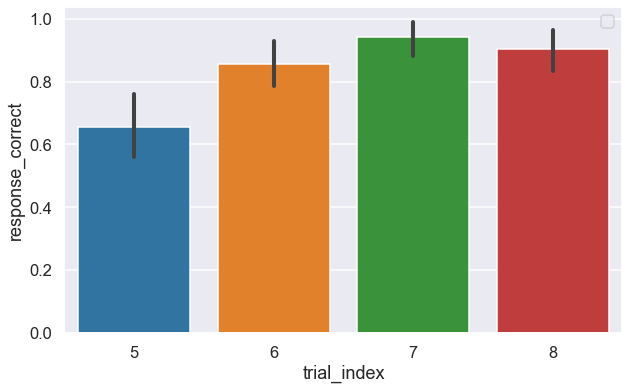

In [34]:
# Do people understand practice trials?

fig = plt.figure(figsize=(10,6))

sns.barplot(data=df_zip_practice, 
              y= "response_correct", 
              x= "trial_index",
              )

plt.legend(bbox_to_anchor=(1,1))

In general yes. Lots of mistakes in the first trial. People reported being thrown off by the mask. But accuracy is v high by the end.

In [147]:
df_zip = df_zip[~df_zip.practice].reset_index(drop=True)

### plot setup

In [148]:
sns.set_context('poster')
sns.set(font_scale=1.2)
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})

## Zipping Trials

/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/U

Text(0.5, 0, 'log(RT)')

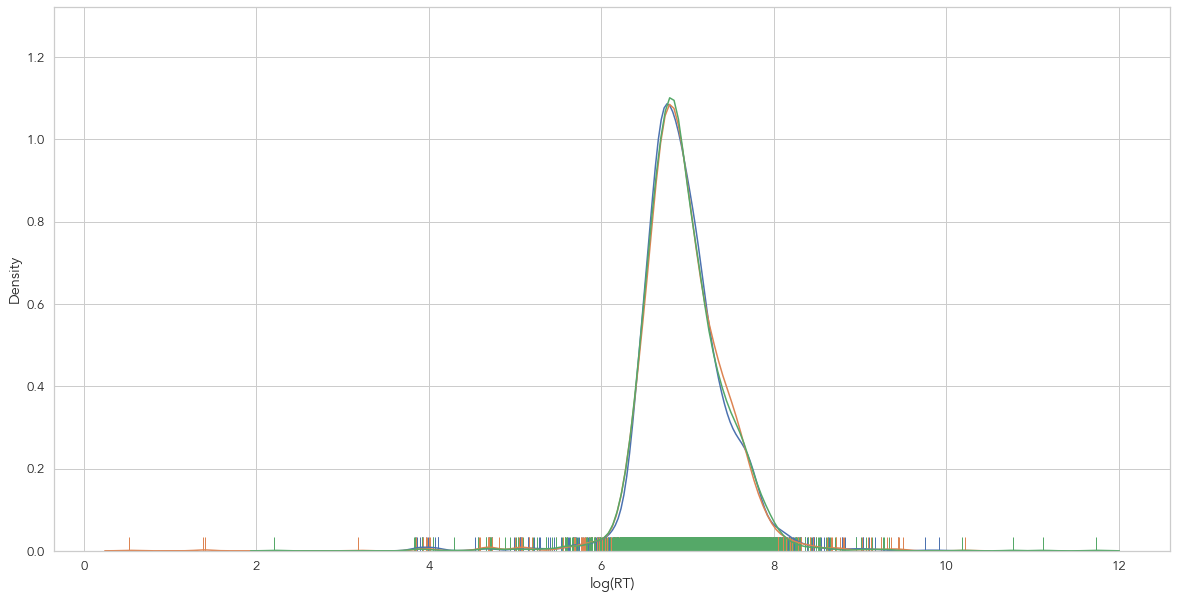

In [149]:
plt.figure(figsize=(20,10))
sns.distplot(np.log(df_zip[df_zip.compatibility == 'compatible'].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[df_zip.compatibility == 'incompatible'].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[df_zip.compatibility == 'novel'].rt), rug=True, hist=False)
plt.xlabel('log(RT)')

In [150]:
df_zip.phase

0         pre_zipping_trials
1         pre_zipping_trials
2         pre_zipping_trials
3         pre_zipping_trials
4         pre_zipping_trials
                ...         
12091    post_zipping_trials
12092    post_zipping_trials
12093    post_zipping_trials
12094    post_zipping_trials
12095    post_zipping_trials
Name: phase, Length: 12096, dtype: object

/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/U

Text(0.5, 0, 'log(RT)')

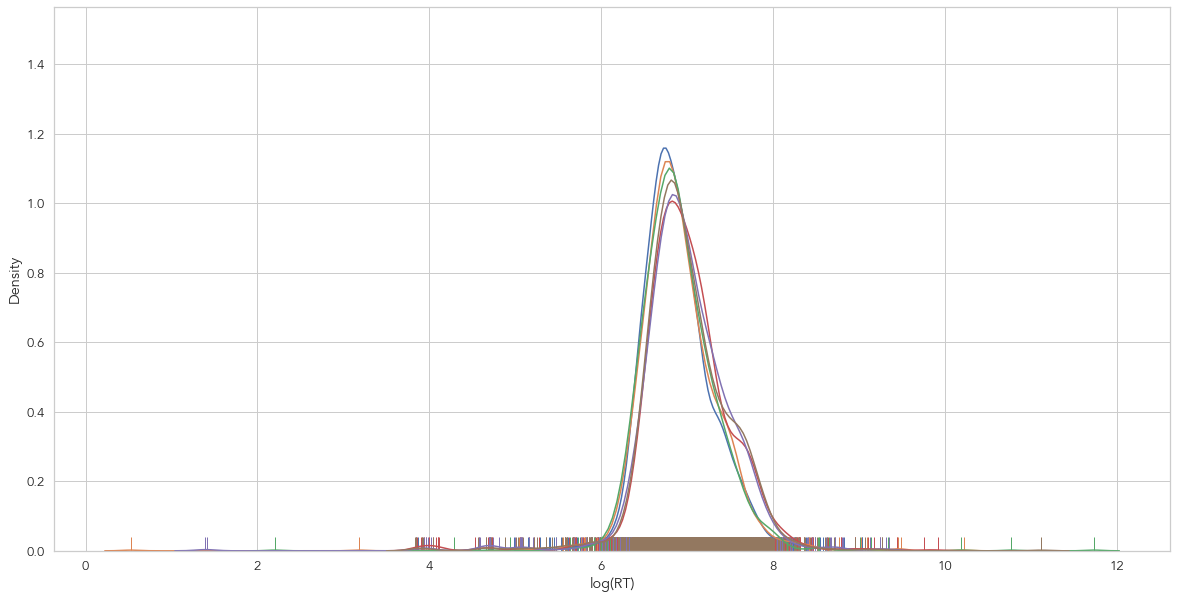

In [151]:
plt.figure(figsize=(20,10))
sns.distplot(np.log(df_zip[(df_zip.compatibility == 'compatible') & (df_zip.phase == 'pre_zipping_trials')].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[(df_zip.compatibility == 'incompatible')& (df_zip.phase == 'pre_zipping_trials')].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[(df_zip.compatibility == 'novel') & (df_zip.phase == 'pre_zipping_trials')].rt), rug=True, hist=False)

sns.distplot(np.log(df_zip[(df_zip.compatibility == 'compatible') & (df_zip.phase == 'post_zipping_trials')].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[(df_zip.compatibility == 'incompatible')& (df_zip.phase == 'post_zipping_trials')].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[(df_zip.compatibility == 'novel') & (df_zip.phase == 'post_zipping_trials')].rt), rug=True, hist=False)
plt.xlabel('log(RT)')

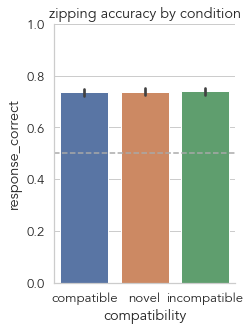

In [152]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="compatibility",
#                 col="trial_num",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
plt.title('zipping accuracy by condition')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

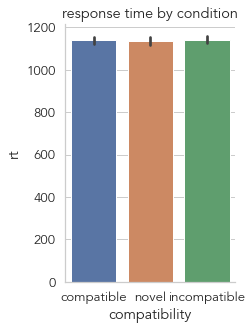

In [153]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt",
                x="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by condition')
plt.show()

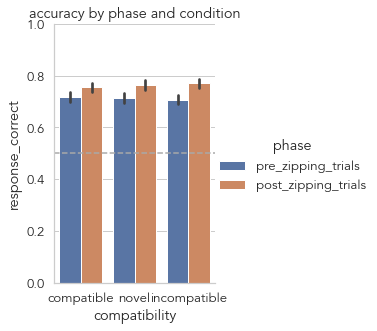

In [154]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                hue="phase",
                x="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.title('accuracy by phase and condition')
plt.show()

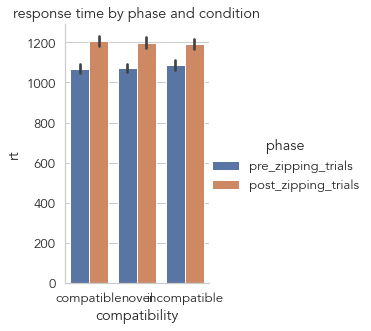

In [155]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                hue="phase",
                x="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by phase and condition')
plt.show()

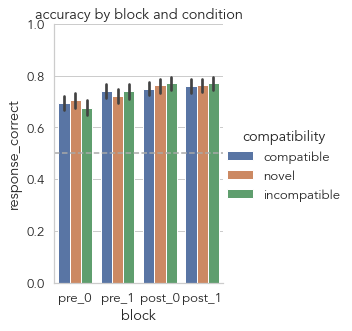

In [156]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="block",
                hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.title('accuracy by block and condition')
plt.show()

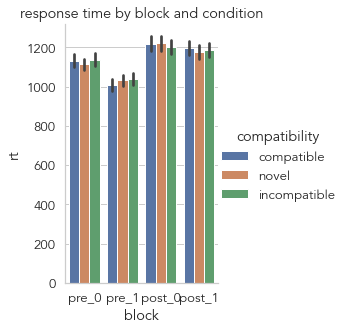

In [157]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by block and condition')
plt.show()

### Investigating an interaction between phase and condition

#### RT

Text(0.5, 1.0, 'response time by phase and condition')

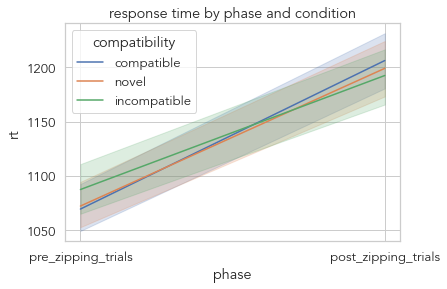

In [174]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="phase",
                hue="compatibility",
            )
plt.title('response time by phase and condition')

Text(0.5, 1.0, 'response time by phase and condition')

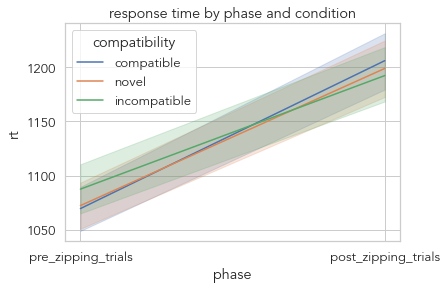

In [169]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="phase",
                hue="compatibility",
            )
plt.title('response time by phase and condition')

sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                hue="compatibility",
            )
plt.title('response time by block and condition')

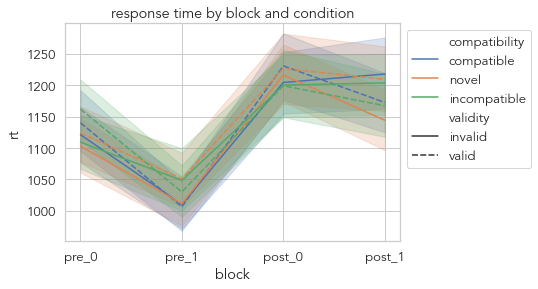

In [168]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                style="validity",
                hue="compatibility",
            )
plt.title('response time by block and condition')
plt.legend(bbox_to_anchor=(1,1))

The expectation was that rt would drop for compatible and (maybe) rise for incompatible.
But RT is higher for all conditions after the building task.
And even after practice they don't get as fast as they used to be.
What's going on?

What's the simplest explanation of this?
People get tired? But then they would continue to get worse.

People are taking longer to parse the objects?
But if so, they're doing it indiscriminantly- there is no difference between novel and built.

#### accuracy

Text(0.5, 1.0, 'accuracy time by phase and condition')

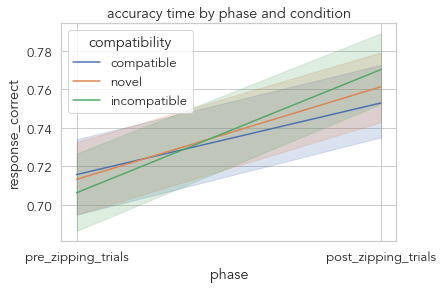

In [163]:
sns.lineplot(data = df_zip,
                y="response_correct", 
                x="phase",
                hue="compatibility",
            )
plt.title('accuracy time by phase and condition')

Text(0.5, 1.0, 'accuracy time by block and condition')

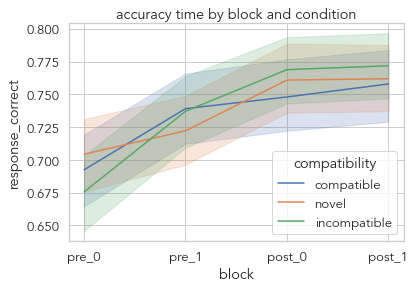

In [164]:
sns.lineplot(data = df_zip,
                y="response_correct", 
                x="block",
                hue="compatibility",
            )
plt.title('accuracy time by block and condition')

But they're more accurate.

### Stimuli

Does the same pattern hold across different stimulus 'rotations'?

There are three stimuli that we rotate into different positions.
Each of the three stims can be novel. And the other two stims can have wide parts built or tall parts built.


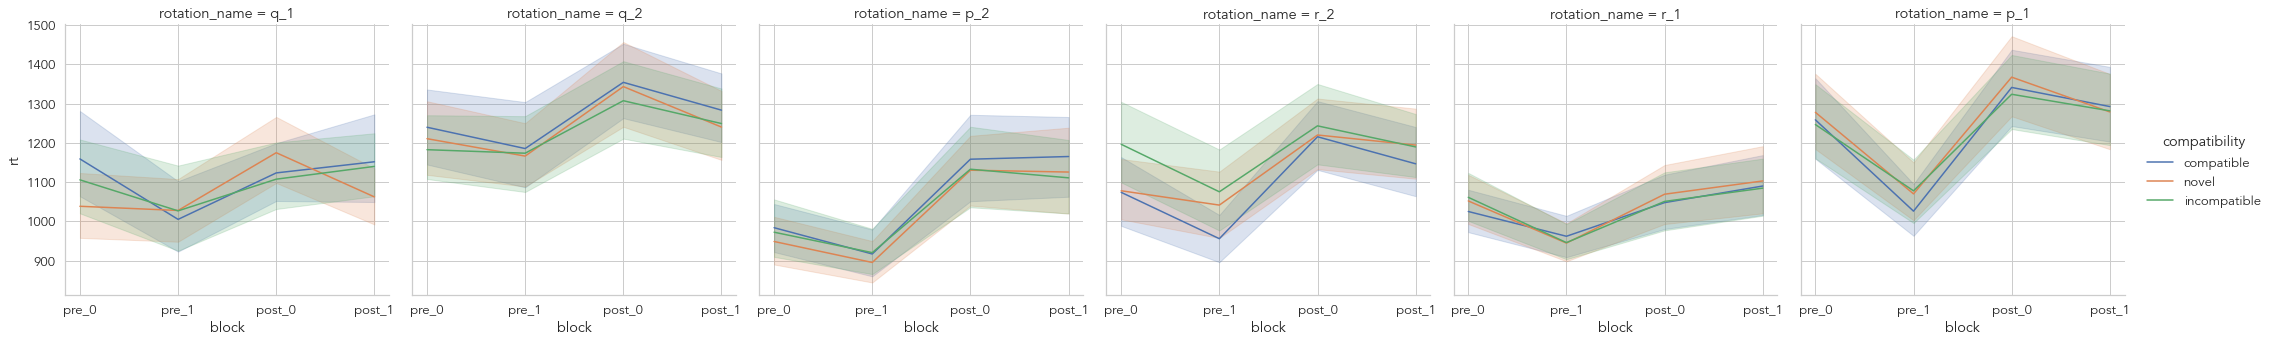

In [78]:
# response time by block and condition, separated by rotation 

f = sns.relplot(data = df_zip[(~df_zip.flagRT)],
                col = 'rotation_name',
                y="rt", 
                x="block",
                hue="compatibility",
                kind='line')

In [ ]:
The general pat

Text(0.5, 1.0, 'accuracy by block and condition')

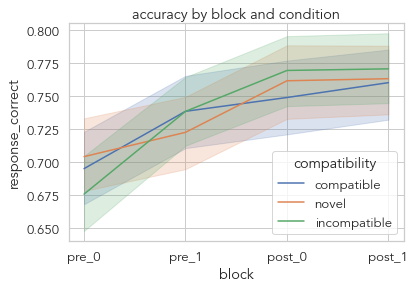

In [79]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="block",
                hue="compatibility",
            )

plt.title('accuracy by block and condition')

Text(0.5, 1.0, 'accuracy by block and condition, separated by rotation')

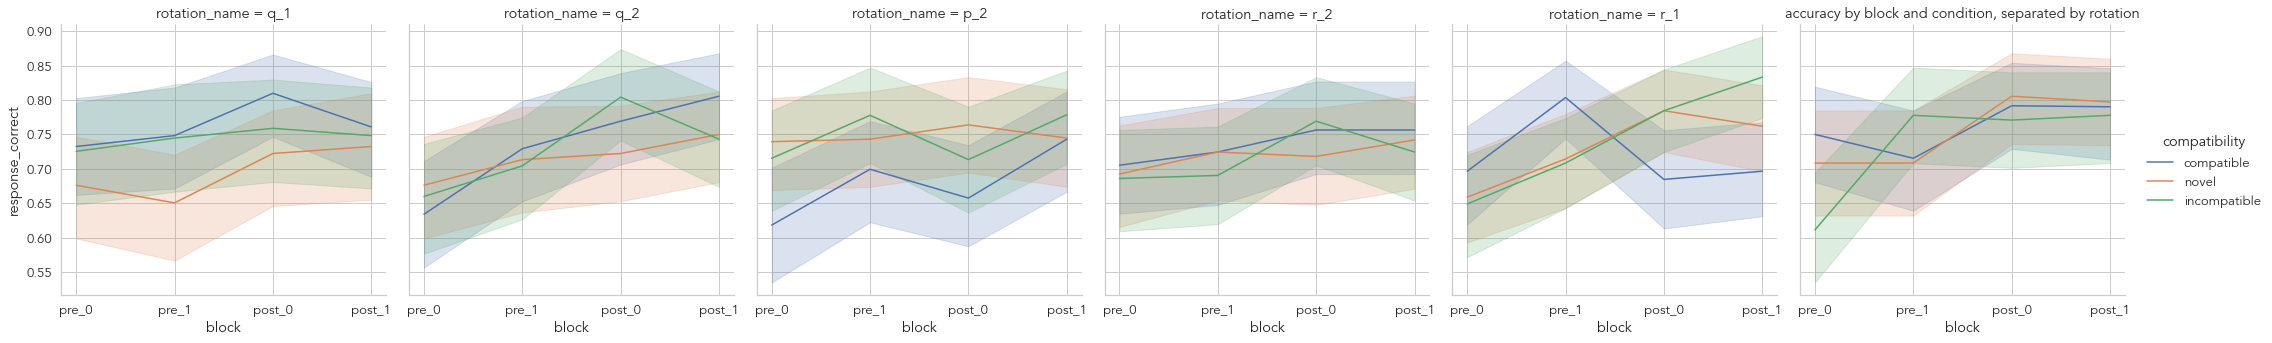

In [80]:
sns.relplot(data = df_zip[(~df_zip.flagRT)],
                col = 'rotation_name',
                y="response_correct", 
                x="block",
                hue="compatibility",
                kind='line')

plt.title('accuracy by block and condition, separated by rotation')

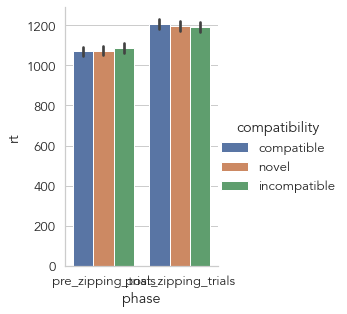

In [49]:
# We want to look at the interaction between phase, compatibility 

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="phase",
                hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()


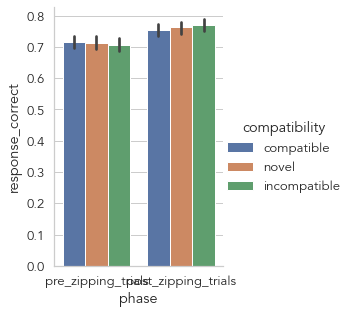

In [50]:
# We want to look at the interaction between phase, compatibility 

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="phase",
                hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

### Look at within-participant, within-condition, between phase differences in RT and accuracy

(i.e. does a person get more accurate or faster for one condition in particular?)

In [176]:
df_zip_phase_mean = df_zip.groupby(['gameID','phase']).mean().reset_index()

In [179]:
def phase_diff(df):
    '''
    Returns difference between rare and phase conditions for response correct and rt
    '''
    diffs = df[df.phase=='post_zipping_trials'][['response_correct','rt']].iloc[0] - df[df.phase=='pre_zipping_trials'][['response_correct','rt']].iloc[0] 
    
    
    diffs = diffs.rename({'response_correct':'diff_response_correct',
                                'rt':'diff_rt'})
    
    return diffs

# start with means
ppt_phase_diffs = df_zip_phase_mean.groupby('gameID')[['response_correct','rt','phase']]

# find differences between phase conditions
ppt_phase_diffs = ppt_phase_diffs.apply(phase_diff)

# merge in useful data from original dataframe
ppt_phase_diffs = ppt_phase_diffs.merge(df_zip.groupby('gameID').first()\
                    [['iterationName','composite_duration']], how='left', on='gameID')

# merge mean columns from original mean dataframe
ppt_phase_diffs = ppt_phase_diffs.merge(df_zip_phase_mean.groupby('gameID').first()\
                    [['rt','response_correct']], how='left', on='gameID')

# and rename mean columns
ppt_phase_diffs = ppt_phase_diffs.rename(columns=
                 {'response_correct':'mean_response_correct',
                                'rt':'mean_rt'})

ppt_phase_diffs

,diff_response_correct,diff_rt,iterationName,composite_duration,mean_rt,mean_response_correct
gameID,,,,,,
0006-45bd8004-9f80-4c7f-aba2-610e170754cb,0.097222,99.958333,pre_post_run_0,600,1307.666667,0.791667
0194-7c828eff-b5e0-4ebc-8d76-c3cb58fefe35,0.166667,66.797222,pre_post_run_0,600,1009.436111,0.861111
0462-c64aea8d-3207-416f-b75e-9ad1e371c8c1,0.027778,46.650000,pre_post_run_0,600,488.851389,0.569444
0583-6b2d7882-0eab-45f9-a075-192f478b0256,0.097222,-79.769444,pre_post_run_0,600,774.104167,0.666667
0642-3e57e41e-831c-4209-b40a-dd7c5bde1e97,0.097222,-144.652778,pre_post_run_0,600,1020.075000,0.625000
...,...,...,...,...,...,...
8604-17243e13-050c-4c1a-b0b6-55c31b777cfa,0.027778,828.522222,pre_post_run_0,600,2417.016667,0.708333
9120-19f24161-e3be-4c42-8796-3429380b5dd2,0.166667,-60.590278,pre_post_run_0,600,958.012500,0.833333
9663-a33e352b-c21f-46a2-b422-70bce3486bc9,0.194444,-51.000000,pre_post_run_0,600,910.930556,0.819444


### Part type

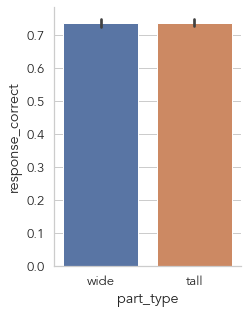

In [51]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="part_type",
#                 hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

### Stimulus

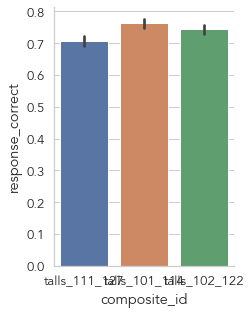

In [52]:
# Is one of the stims easier across the board?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="composite_id",
#                 hue="part_type",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

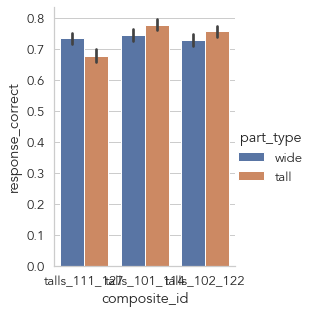

In [53]:
# Are any of the stims easier in one direction?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="composite_id",
                hue="part_type",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

## d'

In [54]:
from scipy.stats import norm

Z = norm.ppf

In [55]:
def d_primes(df):
    
    # find hit rate H, proportion of yes trials with response M
    #df_zip[(df_zip.response=='m') & (df_zip.validity == 'valid')]
    yes_trials = df[df.validity=='valid']
    
    H = len(yes_trials[yes_trials.response==df[df.validity=='valid']['expected_response']])/ len(yes_trials)
    
    # replace hit rates to avoid inf d-prime
#     half_hit = 0.5 / len(yes_trials)
    if H == 1: 
#         H = 1 - half_hit
        H = 0.9999
    if H == 0: 
#         H = half_hit
        H = 0.0001
    

    # find false alarm rate F, proportion of no trials with response M
    no_trials = df[df.validity=='invalid']
    
    F = len(no_trials[no_trials.response!=df[df.validity=='invalid']['expected_response']])/ len(no_trials)
    
    # replace hit rates to avoid inf d-prime
#     half_fa = 0.5 / len(no_trials)
    if F == 1: 
#         F = 1 - half_fa
        F = 0.9999
    if F == 0: 
#         F = half_fa
        F = 0.0001
    
    
    d_prime = Z(H) - Z(F)
    
    return d_prime

In [56]:
d_blocks = df_zip[~df_zip.flagRT].groupby(['gameID','block']).apply(d_primes).reset_index()
d_blocks = d_blocks.rename(columns = {0: 'd_prime'})

<AxesSubplot:xlabel='block', ylabel='d_prime'>

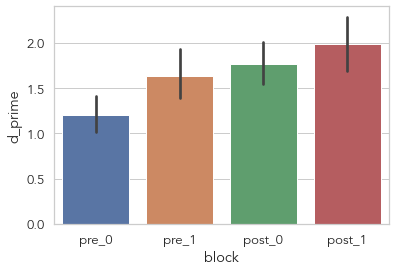

In [57]:
sns.barplot(data = d_blocks,
            y = 'd_prime',
            x = 'block',
            order=block_order)

In [58]:
d_phase = df_zip[~df_zip.flagRT].groupby(['gameID','phase']).apply(d_primes).reset_index()
d_phase = d_phase.rename(columns = {0: 'd_prime'})

<AxesSubplot:xlabel='phase', ylabel='d_prime'>

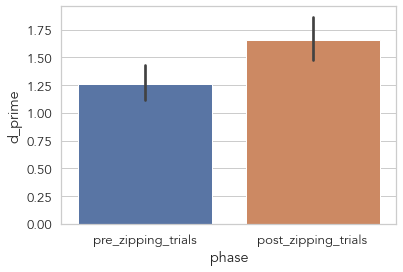

In [59]:
sns.barplot(data = d_phase,
            y = 'd_prime',
            x = 'phase',
            order = phase_order)

In [60]:
d_phase_compatibility = df_zip[~df_zip.flagRT].groupby(['gameID','phase','compatibility']).apply(d_primes).reset_index()
d_phase_compatibility = d_phase_compatibility.rename(columns = {0: 'd_prime'})

<AxesSubplot:xlabel='phase', ylabel='d_prime'>

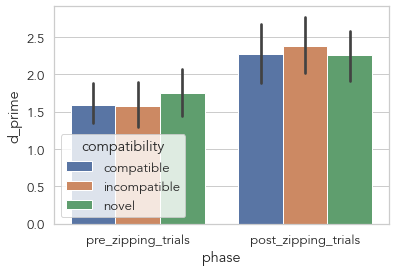

In [61]:
sns.barplot(data = d_phase_compatibility,
            y = 'd_prime',
            x = 'phase',
            hue = 'compatibility',
            order = phase_order)

<AxesSubplot:xlabel='compatibility', ylabel='d_prime'>

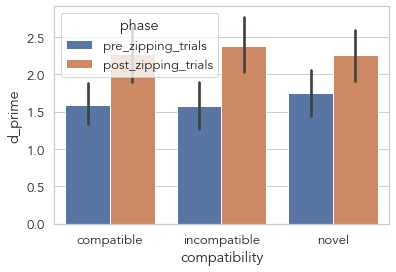

In [62]:
sns.barplot(data = d_phase_compatibility,
            y = 'd_prime',
            hue = 'phase',
            x = 'compatibility',
            hue_order = phase_order)

In [63]:
d_block_compatibility = df_zip[~df_zip.flagRT].groupby(['gameID','block','compatibility']).apply(d_primes).reset_index()
d_block_compatibility = d_block_compatibility.rename(columns = {0: 'd_prime'})

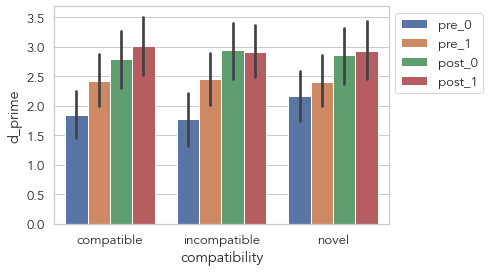

In [64]:
sns.barplot(data = d_block_compatibility,
            y = 'd_prime',
            hue = 'block',
            x = 'compatibility',
            hue_order = block_order)
plt.legend(bbox_to_anchor=(1,1))

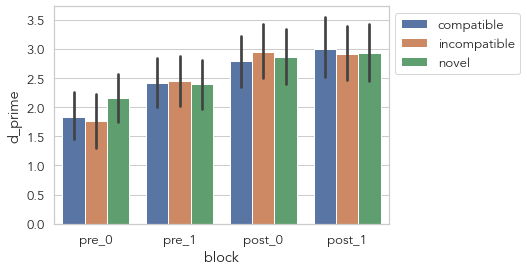

In [65]:
sns.barplot(data = d_block_compatibility,
            y = 'd_prime',
            x = 'block',
            hue = 'compatibility',
            order = block_order)
plt.legend(bbox_to_anchor=(1,1))

## Building Trials

### whole trials

In [58]:
df_build.n_resets # added in pilot_1

0      0
1      0
2      1
3      0
4      1
      ..
379    0
380    0
381    1
382    0
383    0
Name: n_resets, Length: 384, dtype: int64

### individual block placements

In [59]:
df_block_placements

,_id,experimentName,iterationName,workerID,gameID,studyLocation,timeAbsolute,timeRelative,blocks,discreteWorld,...,datatype,stimURL,stimulus,stimId,chunk_id,rep,condition,chunk_type,n_block,n_resets
0,62c720dcedff9c1246774da4,block_construction_zipping,pre_post_run_0,6098423a428aaf2854ad4092,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,Prolific,1.657217e+12,587471,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}]","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",122,tall_122,0,building,tall,1,0
1,62c720e3edff9c1246774da7,block_construction_zipping,pre_post_run_0,6098423a428aaf2854ad4092,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,Prolific,1.657217e+12,594263,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",122,tall_122,0,building,tall,2,0
2,62c720e5edff9c1246774da9,block_construction_zipping,pre_post_run_0,6098423a428aaf2854ad4092,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,Prolific,1.657217e+12,596966,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",122,tall_122,0,building,tall,3,0
3,62c720e6edff9c1246774dab,block_construction_zipping,pre_post_run_0,6098423a428aaf2854ad4092,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,Prolific,1.657217e+12,598087,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",122,tall_122,0,building,tall,4,0
4,62c720ededff9c1246774db0,block_construction_zipping,pre_post_run_0,6098423a428aaf2854ad4092,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,Prolific,1.657217e+12,604838,"[{'x': 4, 'y': 0, 'width': 2, 'height': 1}]","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...",011,wide_011,0,building,wide,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,62c74a30edff9c1246776914,block_construction_zipping,pre_post_run_0,5b1d8c8988ee7400012b2730,0847-640fef5c-bbdb-403b-96f1-595ca984a2af,Prolific,1.657228e+12,2479570,"[{'x': 5, 'y': 0, 'width': 2, 'height': 1}, {'...","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...",111,tall_111,3,building,tall,4,0
2305,62c74a34edff9c1246776917,block_construction_zipping,pre_post_run_0,5b1d8c8988ee7400012b2730,0847-640fef5c-bbdb-403b-96f1-595ca984a2af,Prolific,1.657228e+12,2483834,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}]","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",127,tall_127,3,building,tall,1,0
2306,62c74a36edff9c1246776918,block_construction_zipping,pre_post_run_0,5b1d8c8988ee7400012b2730,0847-640fef5c-bbdb-403b-96f1-595ca984a2af,Prolific,1.657228e+12,2485557,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-silhouettes-j...,"{'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...",127,tall_127,3,building,tall,2,0
2307,62c74a38edff9c1246776919,block_construction_zipping,pre_post_run_0,5b1d8c8988ee7400012b2730,0847-640fef5c-bbdb-403b-96f1-595ca984a2af,Prolific,1.657228e+12,2487203,"[{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...","[[True, True, True, True, True, True, True, Tr...",...,block_placement,https://lax-tower-4-block-unique-s

### resets

In [60]:
df_resets.columns

Index(['_id', 'experimentName', 'iterationName', 'workerID', 'gameID',
       'studyLocation', 'n_blocks_when_reset', 'trial_start_time',
       'relative_time', 'datatype', 'stimURL', 'stimulus', 'stimId',
       'chunk_id', 'rep', 'condition', 'chunk_type', 'n_block', 'n_resets'],
      dtype='object')

In [61]:
import blockworld_utils as utils

In [62]:
# [utils.draw_world(utils.worldify(w)) for w in df_block_placements.blocks]

In [63]:
df_survey

,_id,rt,response,trial_type,trial_index,time_elapsed,internal_node_id,experimentName,iterationName,workerID,gameID,studyLocation,datatype,response_key_dict
0,62c7231dedff9c124677507b,24152.6,"{'technical': 'No', 'confused': 'No', 'comment...",survey-text,176,1163160,0.0-176.0,block_construction_zipping,pre_post_run_0,6098423a428aaf2854ad4092,4722-34dc639d-d0a7-40e6-8974-9fcf153e34e6,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
1,62c7237dedff9c12467750b9,12181.4,"{'technical': 'No', 'confused': 'No', 'comment...",survey-text,176,1237230,0.0-176.0,block_construction_zipping,pre_post_run_0,60a0067f943f8d336ec80fa1,2817-b371118e-ed53-4f8c-a570-8948cf2a0123,Prolific,trial_end,"{'valid': 'm', 'invalid': 'z'}"
2,62c723a4edff9c12467750d7,4539.6,"{'technical': '', 'confused': '', 'comments': ''}",survey-text,176,1221847,0.0-176.0,block_construction_zipping,pre_post_run_0,60dd22f2f6aa769f57e2c55b,1287-eae5bf2b-2731-4660-a20e-b73b9dbe4624,Prolific,trial_end,"{'valid': 'm', 'invalid': 'z'}"
3,62c725d4edff9c12467751de,27195.9,"{'technical': 'No', 'confused': 'No', 'comment...",survey-text,176,1723486,0.0-176.0,block_construction_zipping,pre_post_run_0,5e5580651ffa37588a3697c1,0642-3e57e41e-831c-4209-b40a-dd7c5bde1e97,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
4,62c72914edff9c1246775293,17166.0,"{'technical': 'o', 'confused': 'no', 'comments...",survey-text,176,2289173,0.0-176.0,block_construction_zipping,pre_post_run_0,5bcdb2880ba8a4000125ed43,0006-45bd8004-9f80-4c7f-aba2-610e170754cb,Prolific,trial_end,"{'valid': 'm', 'invalid': 'z'}"
5,62c743baedff9c1246776052,28329.8,"{'technical': '', 'confused': '', 'comments': ''}",survey-text,176,1282965,0.0-176.0,block_construction_zipping,pre_post_run_0,6102bbdba4dd279363094fca,1302-913536d2-7068-4cc3-b278-aa4be9edc302,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
6,62c743bfedff9c1246776064,13076.2,"{'technical': 'no', 'confused': 'no', 'comment...",survey-text,176,1293785,0.0-176.0,block_construction_zipping,pre_post_run_0,603bb3cfd1aca681ef60b8cd,1739-4e73d91f-c931-4343-bc0c-0cfaeef51060,Prolific,trial_end,"{'valid': 'm', 'invalid': 'z'}"
7,62c743f9edff9c1246776129,11426.3,"{'technical': 'no', 'confused': 'no', 'comment...",survey-text,176,1363891,0.0-176.0,block_construction_zipping,pre_post_run_0,5d5a3cc29fe0f0001b0f44a4,3355-95b2fcf7-1cb9-4424-b7bc-57c6b15302fc,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"
8,62c74454edff9c124677623c,30378.2,"{'technical': 'no', 'confused': 'no', 'comment...",survey-text,176,1799297,0.0-176.0,block_construction_zipping,pre_post_run_0,5c5d36bc034e280001644c3b,8700-7d224bf4-f965-4b22-8729-3ebebe3282d3,Prolific,trial_end,"{'valid': 'm', 'invalid': 'z'}"
9,62c744a1edff9c12467762f6,34629.4,"{'technical': 'no', 'confused': 'In part two, ...",survey-text,176,1416238,0.0-176.0,block_construction_zipping,pre_post_run_0,5ed403a89542210ab77530b7,9984-ef648e44-23bb-4658-96f4-7be5c145c151,Prolific,trial_end,"{'valid': 'z', 'invalid': 'm'}"


In [64]:
df_zip.to_csv('../results/zipping/csv/pilot_0_zipping_trials.csv')

In [65]:
!! open .

[]